## Goal is to pick out the key sentence/words from a test

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
from gensim.summarization import summarize
from gensim.summarization import keywords
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
import time as time
import pickle
import random

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from tqdm import tqdm
import multiprocessing as mp

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

In [2]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # replace ;
    text = text.replace(" ; ", "\n")
    
    table = str.maketrans('', '', string.punctuation)
    # get rid of punctuation
    text = text.translate(table)
    
    # get rid of newlines
    text = text.strip().replace("\n", ". ").replace("\r", ".")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

def calc_score(ref, comp, debug=False):
    '''gives the number of items in ref that is also found in comp'''
    ## check if it is a list of strings
    if not isinstance(ref, list):
        ref = str(ref).split()
    if not isinstance(comp, list):
        comp = str(comp).split()
        
    s_ref = set(ref)
    s_comp = set(comp)
    s_inter = s_comp.intersection(s_ref)
    if debug:
        print(s_ref, len(s_ref))
        print(s_comp)
        print(s_inter, len(s_inter))
    try:
        return len(s_inter)/len(s_ref)
    except ZeroDivisionError:
        return 0

In [3]:
# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "\n", "", " ", "\n\n", "npr"]

def lemming(data, keeptype=[], doalpha=False, dostop=True):
    tokens = []
    for tok in data:
        
        # stoplist the tokens
        if dostop:
            if tok.text not in STOPLIST:
                pass
            else:
                continue
            ##check if the token is stopword
            if not tok.is_stop:
                pass
            else:
                continue
        else:
            pass
        
        # stoplist symbols
        if tok.text not in SYMBOLS:
            pass
        else: 
            continue
        
        ##check if the token is alpha
        if doalpha:
            if tok.is_alpha:
                pass
            else:
                continue
        else:
            pass
        
        ##check if the token is noun
        if len(keeptype) > 1:
            if tok.pos_ in keeptype:
                pass
            else:
                continue
        else:
            pass
    
        # lemmatize
        if tok.lemma_ != "-PRON-" :
            tokens.append(tok.lemma_.lower().strip())
        else:
            tokens.append(tok.lower_)
    
    # remove large strings of whitespace
    return tokens

In [4]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

# Initialize vectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [5]:
# ## https://radimrehurek.com/gensim/models/phrases.html
# # rename some functions
# Phraser = models.phrases.Phraser
# Phrases = models.phrases.Phrases

# # Generate list of sentences
# sentence_stream = fulltextdic[0]["text"]

# # Generate bigrams
# phrases = Phrases(sentence_stream, min_count=1, threshold=2)
# bigram = Phraser(phrases)

# # # Generate trigrams 
# # trigram = Phrases(bigram[sentence_stream])

# # Generate output
# output_strs = []

# doc = fulltextdic[0]["text"]
# output_doc = list(bigram[doc])
# output_strs.append(' '.join(output_doc))

# print(doc)
# print(output_strs)

In [8]:
sumtoken = []
token = []
token_filter = []
token_gensim_sentence = []
token_gensim_word = []

##304 NPR, 96 conv, 419 story
path = 'Data/NPR/'
#N = 1
if "_story" in path: ## 31 seconds
    N = 419
elif "_conv" in path: ## 81 seconds
    N = 96
elif "NPR" in path: ## 124 seconds
    N = 304
fulltextdic = {}

def TextToTokens(i=1):
    '''input is file name
    tranlsate the file, file summary'''
    result = {}
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        temp_text = cleanText(myfile.read()) ##this is a string
        #print(type(temp_text))
    with open(path + str(i) + '.txt', 'r') as myfile:
        ## remove the last element which is a date; for summary only
        temp_sumtext = " ".join(cleanText(myfile.read()).split(" ")[:-1]) ## this is also a string
        ##print(temp_sumtext, type(temp_text))
    
    ## add in phrases
#     inputdocument = [d.split(" ") for d in temp_text.split(". ")]
#     phrases = Phrases(inputdocument, min_count=1, threshold=2)
#     bigram = Phraser(phrases)
    
    ## convert to tokens
    nlp_temp_text = nlp("".join(temp_text)) ## this is spacy token
    nlp_temp_sumtext = nlp("".join(temp_sumtext )) ## this is spacy token
    
    ## do lemming
    result["origin"] = temp_text
    result["text"] = lemming(nlp_temp_text) #bigram[lemming(nlp_temp_text)]
    result["sumtext"] = lemming(nlp_temp_sumtext) #bigram[lemming(nlp_temp_sumtext)]
    result["textfilter"] = lemming(nlp_temp_text, doalpha=True, keeptype=["NOUN", "PROPN", "NUM", "ADJ", "ADV"]) #bigram[lemming(nlp_temp_text, doalpha=True, keeptype=["NOUN", "PROPN", "NUM", "ADJ", "ADV"])]
    
#     token.append(lemming(nlp_temp_text))
#     token_alltype.append(lemming(nlp_temp_text, doalpha=False, dostop=True, keeptype=[]))
#     sumtoken.append(lemming(, doalpha=False, dostop=True, keeptype=[]))
    
    ## try gensim sentence
    ratio = len(temp_sumtext)/len(temp_text)
    sum_gensim = summarize("".join(temp_text), ratio=ratio, split=True) #this is a list
    result["gensim_sentence"] = lemming(nlp(" ".join(sum_gensim)))
    
    ## try random sentence
    sentences = temp_text.split(". ")
    n_sentences = len(sum_gensim)
    sum_random = random.choices(sentences, k=n_sentences)
    result["random_sentence"] = lemming(nlp(" ".join(sum_random)))
    
    ## try longest sentence
    sentences.sort(key = lambda x:len(x))
    sum_long = sentences[-n_sentences:]
    #print(sum_long)
    result["long_sentence"] = lemming(nlp(" ".join(sum_long)))
    
    ## gensim keywords; use lemmed full text
    #print(" ".join(result["text"]))
    result["gensim_word"] =  keywords(" ".join(result["text"]), words=len(result["sumtext"]), split=True, lemmatize=True, deacc=True)
    return {i:result}

start_time = time.time()

# inputtasks = range(N)
# npool = min(len(inputtasks), mp.cpu_count()-2)
# print(" Running %s jobs on %s cores" % (len(inputtasks), mp.cpu_count()-2))
# pool  = mp.Pool(npool)

# for r in pool.map(TextToTokens, inputtasks):
#     fulltextdic.update(r)
    
# with open(path + 'fulltextdic.pkl', 'wb') as f:
#     pickle.dump(fulltextdic, f)
    
print("Done!!")
print("--- %s seconds ---" % (time.time() - start_time))
# for i in tqdm(range(2)):
#     fulltextdic.update(TextToTokens(i))

Done!!
--- 0.00047779083251953125 seconds ---


In [9]:

with open(path + 'fulltextdic.pkl', 'rb') as f:
    fulltextdic = pickle.load(f)

In [11]:
best_rate     = []
base_rate     = []
filter_rate   = []
gensimsentence_rate = []
longsentence_rate = []
randomsentence_rate = []
gensimkeyword_rate  = []
comb_rate  = []

for i in tqdm(range(N)):
#for i in tqdm(range(1, 2)):
    ## calculate the maximum score
    token = fulltextdic[i]["text"]
    token_sum = fulltextdic[i]["sumtext"]
    token_filter = fulltextdic[i]["textfilter"]
    token_gensimsentence = fulltextdic[i]["gensim_sentence"]
    token_randomsentence = fulltextdic[i]["random_sentence"]
    token_longsentence = fulltextdic[i]["long_sentence"]
    token_gensimkeyword = fulltextdic[i]["gensim_word"]
    length = len(token_sum)
    
    ## best score: Nwords in sum also in token
    best_score = calc_score(ref=token_sum, comp=token, debug=False)
    
    ## baseline score: high frequency words
    words_base = [w[0] for w in Counter(token).most_common(length)]
    words_base.sort(key=lambda x: token.index(x))
    base_score =  calc_score(ref=token_sum, comp=words_base, debug=False)

    words_filter = [w[0] for w in Counter(token_filter).most_common(length)]
    words_filter.sort(key=lambda x: token_filter.index(x))
    filter_score = calc_score(ref=token_sum, comp=words_filter, debug=False)
    
    gensimsentence_score = calc_score(ref=token_sum, comp=token_gensimsentence, debug=False)
    randomsentence_score = calc_score(ref=token_sum, comp=token_randomsentence, debug=False)
    longsentence_score = calc_score(ref=token_sum, comp=token_longsentence, debug=False)

    gensimkeyword_score = calc_score(ref=token_sum, comp=token_gensimkeyword, debug=False)
    
    comb_words = [w[0] for w in Counter(words_filter + token_gensimsentence ).most_common(length)]
    comb_score = calc_score(ref=token_sum, comp=comb_words, debug=False)
    
    best_rate.append(best_score)
    base_rate.append(base_score * 100)
    filter_rate.append(filter_score * 100)
    gensimsentence_rate.append(gensimsentence_score * 100)
    randomsentence_rate.append(randomsentence_score * 100)
    longsentence_rate.append(longsentence_score * 100)
    gensimkeyword_rate.append(gensimkeyword_score * 100)
    comb_rate.append(comb_score * 100)
    
    if gensimsentence_score > 0.8:
        print("This is the", i, "file")
        print(" ".join(token_sum))
        print("best score", best_score, "\n")
        print(" ".join(words_base))
        print("baseline score", base_score, "\n")
        print(" ".join(token_gensimsentence))
        print(" ".join(token_randomsentence))
        print(" ".join(token_longsentence))
        print("gensimsentence score", gensimsentence_score, "\n")
        print(" ".join(words_filter))
        print("filter word score", filter_score, "\n")
        print(" ".join(token_gensimkeyword))
        print("gensimskeyword score", gensimkeyword_score, "\n")
        print(" ".join(comb_words))
        print("comb score", comb_score, "\n")
        #print(token)

100%|██████████| 304/304 [00:00<00:00, 1528.77it/s]


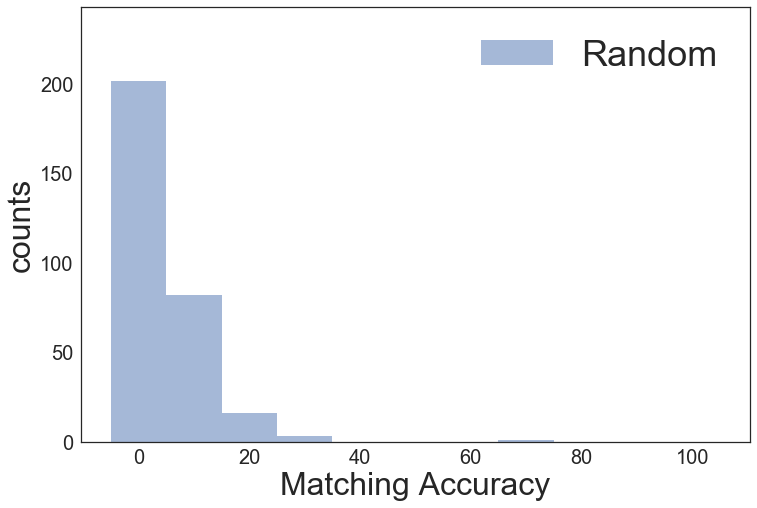

In [12]:
plt.clf()
plt.figure(figsize=(12, 8))
mybins=np.arange(-5, 115, 10)
#plt.hist(base_rate, alpha=0.5, bins=mybins, label="Baseline") # mean %.3f %s %.3f " % (np.mean(np.array(base_rate)), r'$\pm$', np.std(np.array(base_rate)/np.sqrt(N))))
#plt.hist(filter_rate, alpha=0.5, bins=mybins, label="Filtered") #; mean %.3f %s %.3f" % (np.mean(np.array(my_rate)), r'$\pm$', np.std(np.array(my_rate))/np.sqrt(N)))
plt.hist(randomsentence_rate, alpha=0.5, bins=mybins, label="Random") #; mean %.3f %s %.3f " % (np.mean(np.array(gensim_rate)), r'$\pm$', np.std(np.array(gensim_rate)/np.sqrt(N))))
#plt.hist(longsentence_rate,   alpha=0.6, bins=mybins, label="Longest") #; mean %.3f %s %.3f " % (np.mean(np.array(gensim_rate)), r'$\pm$', np.std(np.array(gensim_rate)/np.sqrt(N))))
#plt.hist(gensimsentence_rate, alpha=0.8, bins=mybins, label="TextRank") #; mean %.3f %s %.3f " % (np.mean(np.array(gensim_rate)), r'$\pm$', np.std(np.array(gensim_rate)/np.sqrt(N))))
#plt.hist(gensimkeyword_rate, alpha=0.5, bins=mybins, label="Gensim keywords") #; mean %.3f %s %.3f " % (np.mean(np.array(gensimkeyword_rate)), r'$\pm$', np.std(np.array(gensimkeyword_rate)/np.sqrt(N))))
#plt.hist(comb_rate, alpha=0.5, bins=mybins, label="My highlights mean %.3f %s %.3f " % (np.mean(np.array(comb_rate)), r'$\pm$', np.std(np.array(comb_rate)/np.sqrt(N))))
plt.ylim(0, N/5*4)
#plt.xlabel(r"$N_{matched}^{InDescription}$ / $N_{total}^{InDescription}$", fontsize=32)
plt.xlabel("Matching Accuracy", fontsize=32)
plt.ylabel("counts", fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=40)
plt.legend(fontsize=36)
plt.savefig("Plot/" + path.split("/")[1] + "_randomsentence.pdf")
plt.show()

In [122]:
with open(path + 'info.pkl', 'rb') as f:
    alldic = pickle.load(f)
df = pd.DataFrame(alldic).transpose()
print(df.head())

                         dBFS    duration      max  max_dBFS     rms
Data/NPR/0.wav     -21.109094  802.612245  29039.0 -1.049366  2884.0
Data/NPR/0_0.wav   -20.274124    5.690000  27872.0 -1.405636  3175.0
Data/NPR/0_1.wav   -21.500263    2.100000  24238.0 -2.619063  2757.0
Data/NPR/0_10.wav  -19.173303    7.220000  28798.0 -1.121752  3604.0
Data/NPR/0_100.wav -28.725374    0.660000  10706.0 -9.716454  1200.0


## Pandas study
## Studies the audio information's relationship with the sentences
## Goal is to use sound loundess etc. to help model the importance of a sentence

In [128]:
all_sentence_dic = {}
def sentence_score(i):
    ## ML studies
    tempdict = {}
    temptextlist = fulltextdic[i]["origin"].split(". ")
    for j in range(len(temptextlist)):
        sentence_dic = {}
        try:
            sentence_dic.update(alldic[path + str(i) + '_' + str(j) + '.wav'])
        except KeyError:
            continue
        sentence_dic["words"] = lemming(nlp(temptextlist[j]))
        sentence_dic["ref"] = fulltextdic[i]["sumtext"]
        sentence_dic["score"] = calc_score(ref=sentence_dic["ref"], comp=sentence_dic["words"], debug=False)
        if len(sentence_dic["words"]) < 4: ## don't keep too short sentences
            continue
        tempdict[str(i) + '_' + str(j)] = sentence_dic
    return tempdict
    
start_time = time.time()
inputtasks = range(N)
npool = min(len(inputtasks), mp.cpu_count()-2)
print(" Running %s jobs on %s cores" % (len(inputtasks), mp.cpu_count()-2))
pool  = mp.Pool(npool)

for r in pool.map(sentence_score, inputtasks):
    all_sentence_dic.update(r)

print("Done!!")
print("--- %s seconds ---" % (time.time() - start_time))

 Running 304 jobs on 6 cores


Done!!
--- 130.99301409721375 seconds ---


In [129]:
df = pd.DataFrame(all_sentence_dic).transpose()
df.to_csv(path + "all_sentence_dic.csv")

In [4]:
df = pd.read_csv(path + "all_sentence_dic.csv", index_col=0)

## Quick inspection

In [5]:
df.head()

,dBFS,duration,max,max_dBFS,ref,rms,score,words
0_0,-20.274124,5.69,27872,-1.405636,"['meet', 'kim', 'jong', 'president', 'trump', ...",3175,0.000000,"['wish', 'congratulate', 'couple', 'friend', '..."
0_1,-21.500263,2.10,24238,-2.619063,"['meet', 'kim', 'jong', 'president', 'trump', ...",2757,0.000000,"['michael', 'gordon', 'morning', 'like']"
0_10,-19.173303,7.22,28798,-1.121752,"['meet', 'kim', 'jong', 'president', 'trump', ...",3604,0.083333,"['leader', 'large', 'western', 'economy', 'lon..."
0_100,-28.725374,0.66,10706,-9.716454,"['meet', 'kim', 'jong', 'president', 'trump', ...",1200,0.000000,"['try', 'convince', 'maybe', 'change', 'method..."
0_101,-24.867523,1.54,18831,-4.811531,"['meet', 'kim', 'jong', 'president', 'trump', ...",1871,0.041667,"['expectation', 'effect', 'good', 'doer', 'cas..."


In [6]:
df['length'] = df['words'].apply(len)

In [7]:
df["dBFS"] = df["dBFS"].values.astype(float)
df["max_dBFS"] = df["max_dBFS"].values.astype(float)
df["duration"] = df["duration"].values.astype(float)
df["length"] = df["length"].values.astype(int)
df["score"] = df["score"].values.astype(float)
df["wordduration"] = df["duration"]/(df["length"] + 1)
df["DeltadBFS"] = -(df["max_dBFS"] - df["dBFS"])/df["dBFS"]

In [8]:
df['rankmax'] = df['max_dBFS'].rank(ascending=1, pct=True)
df['rankave'] = df['dBFS'].rank(ascending=1, pct=True)
for i in tqdm(range(N)):
    df_temp = df.loc[df.index.str.startswith(str(i) + "_")].copy()
    df_temp['rankmax'] = df_temp['max_dBFS'].rank(ascending=1, pct=True)
    df_temp['rankave'] = df_temp['dBFS'].rank(ascending=1, pct=True)
    #print(df_temp.shape, max(df_temp['rankmax']))
    df.loc[df.index.str.startswith(str(i) + "_")] = df_temp

100%|██████████| 304/304 [00:09<00:00, 31.22it/s]


highrank mean 0.037 err 0.000 lowrank 0.025 err 0.000


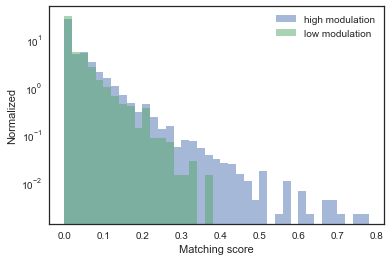

In [78]:
plt.clf()
threshold_rankmax = 0.95
threshold_deltadBFS = 0.78
highrank = df[(df['DeltadBFS'] > threshold_deltadBFS)]['score'].values
lowrank = df[(df['DeltadBFS'] < threshold_deltadBFS)]['score'].values
#sns.distplot(highrank, label='highrank')
#sns.distplot(lowrank, label='lowrank')
plt.hist(highrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='high modulation', normed=True)
plt.hist(lowrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='low modulation', normed=True)
print("highrank mean %.3f err %.3f" % (np.mean(highrank), np.std(highrank)/np.sqrt(len(highrank))), "lowrank %.3f err %.3f" % (np.mean(lowrank), np.std(lowrank)/np.sqrt(len(highrank))))
plt.yscale('log', nonposy='clip')
plt.xlabel('Matching score')
plt.ylabel('Normalized')
plt.legend()
plt.savefig("Plot/" + path.split("/")[1] + "_modulation.pdf")
plt.show()

highrank mean 0.052 err 0.003 lowrank 0.035 err 0.002


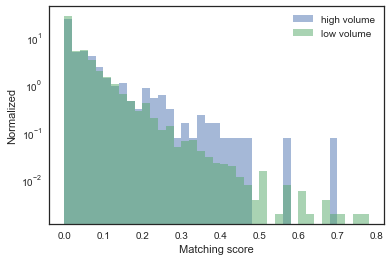

In [79]:
plt.clf()
threshold_rankmax = 0.98
threshold_deltadBFS = 0.9
highrank = df[(df['rankmax'] > threshold_rankmax)]['score'].values
lowrank = df[(df['rankmax'] < threshold_rankmax)]['score'].values
#sns.distplot(highrank, label='highrank')
#sns.distplot(lowrank, label='lowrank')
plt.hist(highrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='high volume', normed=True)
plt.hist(lowrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='low volume', normed=True)
print("highrank mean %.3f err %.3f" % (np.mean(highrank), np.std(highrank)/np.sqrt(len(highrank))), "lowrank %.3f err %.3f" % (np.mean(lowrank), np.std(lowrank)/np.sqrt(len(highrank))))
plt.yscale('log', nonposy='clip')
plt.xlabel('Matching score')
plt.ylabel('Normalized')
plt.legend()
plt.savefig("Plot/" + path.split("/")[1] + "_volume.pdf")
plt.show()

highrank mean 0.037 err 0.000 lowrank 0.025 err 0.000


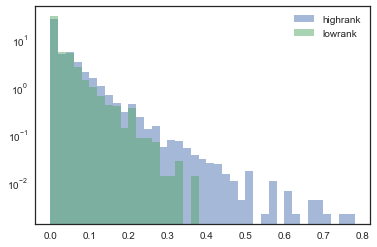

In [76]:
plt.clf()
threshold_rankmax = 0.98
threshold_deltadBFS = 0.78
highrank = df[((df['DeltadBFS'] > threshold_deltadBFS) |  (df['rankmax'] > threshold_rankmax))]['score'].values
lowrank = df[((df['DeltadBFS'] < threshold_deltadBFS) &  (df['rankmax'] < threshold_rankmax) )]['score'].values
#sns.distplot(highrank, label='highrank')
#sns.distplot(lowrank, label='lowrank')
plt.hist(highrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='highrank', normed=True)
plt.hist(lowrank, bins=np.arange(0, 0.8, 0.02), alpha=0.5, label='lowrank', normed=True)
print("highrank mean %.3f err %.3f" % (np.mean(highrank), np.std(highrank)/np.sqrt(len(highrank))), "lowrank %.3f err %.3f" % (np.mean(lowrank), np.std(lowrank)/np.sqrt(len(highrank))))
plt.yscale('log', nonposy='clip')
plt.legend()
plt.show()

## There are some saparation from volume modulation and sound modulation but not great
## Will give up and save this as something to do for the future

In [34]:
np.mean(df[(df['score'] > 0.001) & (df['rankmax'] > 0.9)]['score'])

0.09374857017358763

In [35]:
df.head()

,dBFS,duration,max,max_dBFS,ref,rms,score,words,length,wordduration,DeltadBFS,rankmax,rankave
0_0,-20.274124,5.69,27872,-1.405636,"['meet', 'kim', 'jong', 'president', 'trump', ...",3175,0.000000,"['wish', 'congratulate', 'couple', 'friend', '...",94,0.059895,0.930668,0.688889,0.744444
0_1,-21.500263,2.10,24238,-2.619063,"['meet', 'kim', 'jong', 'president', 'trump', ...",2757,0.000000,"['michael', 'gordon', 'morning', 'like']",40,0.051220,0.878185,0.522222,0.383333
0_10,-19.173303,7.22,28798,-1.121752,"['meet', 'kim', 'jong', 'president', 'trump', ...",3604,0.083333,"['leader', 'large', 'western', 'economy', 'lon...",101,0.070784,0.941494,0.944444,0.922222
0_100,-28.725374,0.66,10706,-9.716454,"['meet', 'kim', 'jong', 'president', 'trump', ...",1200,0.000000,"['try', 'convince', 'maybe', 'change', 'method...",129,0.005077,0.661747,0.044444,0.044444
0_101,-24.867523,1.54,18831,-4.811531,"['meet', 'kim', 'jong', 'president', 'trump', ...",1871,0.041667,"['expectation', 'effect', 'good', 'doer', 'cas...",106,0.014393,0.806513,0.222222,0.111111


/Users/renormalization/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/Users/renormalization/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


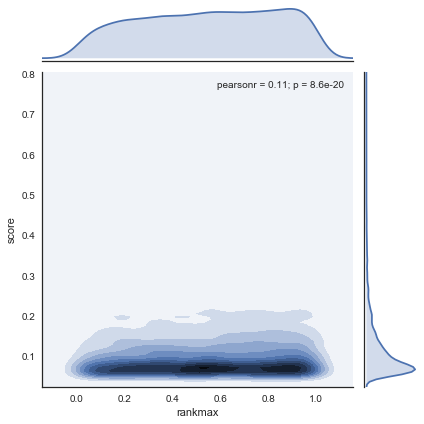

In [36]:
sns.jointplot(x="rankmax", y="score", data=df[df['score'] > 0.05], kind="kde")

In [37]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor

In [38]:
X = df[(df["duration"] > 1) & (df["length"] > 3)][["DeltadBFS", "duration", "wordduration", "rankmax", "rankave"]]
y = df[(df["duration"] > 1) & (df["length"] > 3)][["score"]]
#y = np.log(y / (1 - y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(16178, 5)

In [39]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr.coef_

array([[-0.01133544,  0.00422445, -0.27943897,  0.00266556,  0.00701982]])

In [40]:
# Make predictions using the testing set
y_pred = lr.predict(X_val)

# The coefficients
print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(y_val, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_val, y_pred))

Coefficients: 
 [[-0.01133544  0.00422445 -0.27943897  0.00266556  0.00701982]]
Mean squared error: 0.00327
Variance score: 0.14


In [41]:
# #############################################################################
# Fit regression model
n_neighbors = 50

knn = neighbors.KNeighborsRegressor(n_neighbors)
yknn = knn.fit(X_train, y_train).predict(X_val)

print("Mean squared error: %.5f"
      % mean_squared_error(y_val, yknn))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_val, yknn))

Mean squared error: 0.00338
Variance score: 0.11


In [42]:
RF = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
yRF = RF.fit(X_train, y_train).predict(X_val)
print("Mean squared error: %.5f"
      % mean_squared_error(y_val, yRF))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_val, yRF))

/Users/renormalization/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Mean squared error: 0.00317
Variance score: 0.17


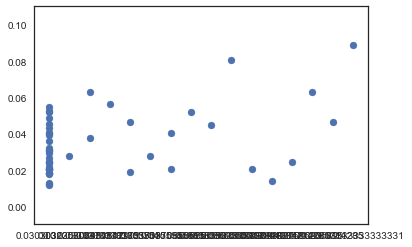

In [43]:
plt.clf()
plt.scatter(y_val[:50], yRF[:50])
plt.show()